# Pre-Processing and Modelling of Movie Recommendation System

## Problem statement recap: 

How can data from a movie-based platform recommend other movies to users based on their preferences and activities on that platform?

## Types of Recommendation Systems

There are three types of recommendation systems:

1.	Content-based Filtering: These suggest recommendations based on the item metadata (movie, product, song, etc). Here, the main idea is that if a user likes an item, they will also like items like it.
2.	Demographic Filtering: The recommendations are the same for every user. They are generalised, not personalised. These types of systems are behind sections like “Top Trending”.
3.	Collaboration-based Filtering: These systems make recommendations by grouping users with similar interests. For this system, metadata of the item is not required. 

My original idea was to create a recommendation system focused on Content-based filtering, but I will also include demographic filtering. I will not be including collaboration-based filtering because I do not have a userID, which is necessary for collaborative filtering, and therefore another dataset would have to be used.  


## A quick data wrangling and EDA

In [1]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
from ast import literal_eval
import matplotlib
#reconfigure default settings
sns.set_palette(sns.color_palette("hls", 8))
matplotlib.rc('figure', figsize = (20, 8))
matplotlib.rc('font', size = 14)
matplotlib.rc('axes.spines', top = False, right = False)
matplotlib.rc('axes', grid = False)
matplotlib.rc('axes', facecolor = 'white')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [2]:
# Load the csv files
credits_data = pd.read_csv("/Users/courtneydavid/Documents/Data Science Springboard Career Track Course/Capstone 3/Movie Rec System/tmdb_5000_credits.csv")
movies_data = pd.read_csv("/Users/courtneydavid/Documents/Data Science Springboard Career Track Course/Capstone 3/Movie Rec System/tmdb_5000_movies.csv")

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

## Merge the two datasets

In [4]:
credits_data.columns = ['id','title','cast','crew']

movies_data = movies_data.merge(credits_data, on="id")

In [5]:
movies_data.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title_x,vote_average,vote_count,title_y,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


# Content Based Filtering

## Plot description based Recommender

In [6]:
movies_data['overview'].head(5)

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
3    Following the death of District Attorney Harve...
4    John Carter is a war-weary, former military ca...
Name: overview, dtype: object

I need to convert the word vector of each overview. I will use the Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each overview. Frequency is related to the frequency of a word in a document. Inverse Document Frequency is the relative count of documents containing the term given as a log (number of documents/documents with the term). The overall importance of each word to the documents in which they appear is equal to TF * IDF. This will give you a matrix where each column represents a word in the overview vocabulary (all the words that appear in at least one document), and each row represents a movie, as before. This reduces the importance of words frequently occurring in plot overviews and their significance in computing the final similarity score.
To save time, TfIdfVectorizer from scikit-learn will be used. 


In [7]:
tfidf = TfidfVectorizer(stop_words='english')
movies_data['overview'] = movies_data['overview'].fillna('')
tfidf_matrix = tfidf.fit_transform(movies_data['overview'])
tfidf_matrix.shape

(4803, 20978)

With this matrix in hand, we can now compute a similarity score. There are several candidates for this, such as the Euclidean, Pearson and cosine similarity scores. I will be using the cosine similarity to calculate a numeric quantity that denotes the similarity between two movies. I am using the cosine similarity score since it is independent of magnitude and is relatively easy and fast to calculate. Mathematically, it is defined as follows: 
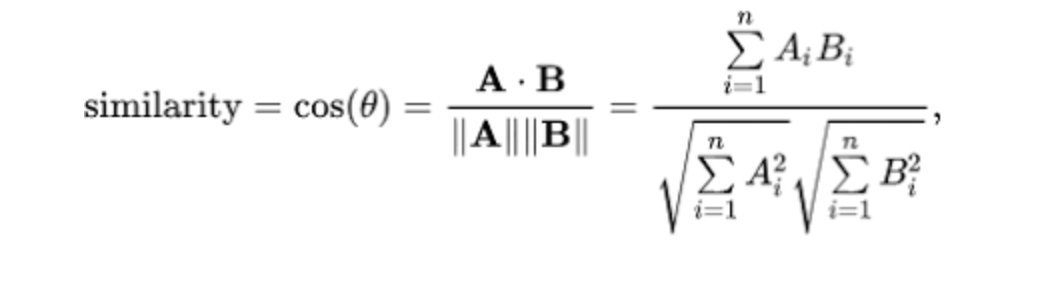

I am using sklearn's linear_kernel() instead of cosine_similarities() since it is faster.

In [8]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

I have defined a function below that takes a movie title as an input and outputs a list of the 10 most similar movies. I also need a mechanism to identify the index of a move in the metadata Data frame given its title. 

In [11]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(movies_data.index, index=movies_data['title_x']).drop_duplicates()

In [14]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return movies_data['title_x'].iloc[movie_indices]

In [16]:
get_recommendations('Avatar')

3604                       Apollo 18
2130                    The American
634                       The Matrix
1341            The Inhabited Island
529                 Tears of the Sun
1610                           Hanna
311     The Adventures of Pluto Nash
847                         Semi-Pro
775                        Supernova
2628             Blood and Chocolate
Name: title_x, dtype: object

In [22]:
get_recommendations('The Dark Knight Rises')

65                              The Dark Knight
299                              Batman Forever
428                              Batman Returns
1359                                     Batman
3854    Batman: The Dark Knight Returns, Part 2
119                               Batman Begins
2507                                  Slow Burn
9            Batman v Superman: Dawn of Justice
1181                                        JFK
210                              Batman & Robin
Name: title_x, dtype: object

I do not think this system has done a good enough job with recommendations and it returns movies of the same/similar title instead of broadening the range.

# Credits, Genres and Keywords Based Recommender

Our recommendation system would be improved if there were better metadata. I want to explore and build a recommendation system based on the following metadata: the director, related genres actors and movie plot keywords. 

In [23]:
# Parse the stringified features into their corresponding python objects
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    movies_data[feature] = movies_data[feature].apply(literal_eval)

In [24]:
# Get the director's name from the crew feature. If director is not listed, return NaN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [25]:
# Returns the list top 3 elements or entire list; whichever is more.
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

In [26]:
# Define new director, cast, genres and keywords features that are in a suitable form.
movies_data['director'] = movies_data['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    movies_data[feature] = movies_data[feature].apply(get_list)

In [28]:
# Print the new features of the first 3 films
movies_data[['title_x', 'cast', 'director', 'keywords', 'genres']].head(3)

,title_x,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"


The next step would be to convert the names and keyword instances into lowercase and strip all the spaces between them.

In [29]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [30]:
# Apply clean_data function to your features.
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    movies_data[feature] = movies_data[feature].apply(clean_data)

I have created a string that contains all the metadata that I want to feed into the vectorizer. 

In [31]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
movies_data['soup'] = movies_data.apply(create_soup, axis=1)

In [32]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(movies_data['soup'])

In [33]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [35]:
# Reset index of our main DataFrame and construct reverse mapping as before
movies_data = movies_data.reset_index()
indices = pd.Series(movies_data.index, index=movies_data['title_x'])

Now I can reuse the get_recommendations() function by passing in the new cosine_sim2 matrix as the second argument.

In [36]:
get_recommendations('The Dark Knight Rises', cosine_sim2)

65               The Dark Knight
119                Batman Begins
4638    Amidst the Devil's Wings
1196                The Prestige
3073           Romeo Is Bleeding
3326              Black November
1503                      Takers
1986                      Faster
303                     Catwoman
747               Gangster Squad
Name: title_x, dtype: object

In [37]:
get_recommendations('Avatar', cosine_sim2)

206                         Clash of the Titans
71        The Mummy: Tomb of the Dragon Emperor
786                           The Monkey King 2
103                   The Sorcerer's Apprentice
131                                     G-Force
215      Fantastic 4: Rise of the Silver Surfer
466                            The Time Machine
715                           The Scorpion King
1      Pirates of the Caribbean: At World's End
5                                  Spider-Man 3
Name: title_x, dtype: object

Now, I think the recommendation system is much more successful in capturing more information due to the metadata and have given better recommendations.

# Demographic Filtering

For this demographic filter, I need a metric to score or rate a movie, calculate the score for every movie, sort the scores and recommend the best-rated movies to users. In order to do this, I will be using IMDB's weighted rating (wr) which is given as :
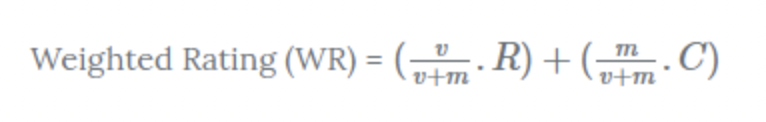

where,
•	v is the number of votes for the movie;
•	m is the minimum votes required to be listed in the chart;
•	R is the average rating of the movie; And
•	C is the mean vote across the whole report


In [39]:
# We already have v(vote_count) and R (vote_average) and C can be calculated as
C= movies_data['vote_average'].mean()
C

6.092171559442011

The mean rating for all the movies is approximately six on a scale of 10. The next step is determining an appropriate value for m, the minimum votes required to be listed in the chart, and I will use the 90th percentile as our cut-off. In other words, for a movie to feature in the charts, it must have more votes than at least 90% of the film in the list.

In [40]:
m= movies_data['vote_count'].quantile(0.9)
m

1838.4000000000015

I will be filtering out the movies that qualify for the chart. 

In [41]:
q_movies = movies_data.copy().loc[movies_data['vote_count'] >= m]
q_movies.shape

(481, 27)

I want to define a function called weighted_rating() and define a new feature score, of which will calculate the value by applying this function to the data frame of qualified movies.

In [42]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [43]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

In [45]:
#Sort movies based on score calculated above
q_movies = q_movies.sort_values('score', ascending=False)

#Print the top 15 movies
q_movies[['title_x', 'vote_count', 'vote_average', 'score']].head(10)

,title_x,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.059258
662,Fight Club,9413,8.3,7.939256
65,The Dark Knight,12002,8.2,7.920020
3232,Pulp Fiction,8428,8.3,7.904645
96,Inception,13752,8.1,7.863239
3337,The Godfather,5893,8.4,7.851236
95,Interstellar,10867,8.1,7.809479
809,Forrest Gump,7927,8.2,7.803188
329,The Lord of the Rings: The Return of the King,8064,8.1,7.727243
1990,The Empire Strikes Back,5879,8.2,7.697884


Text(0.5, 1.0, 'Popular Movies')

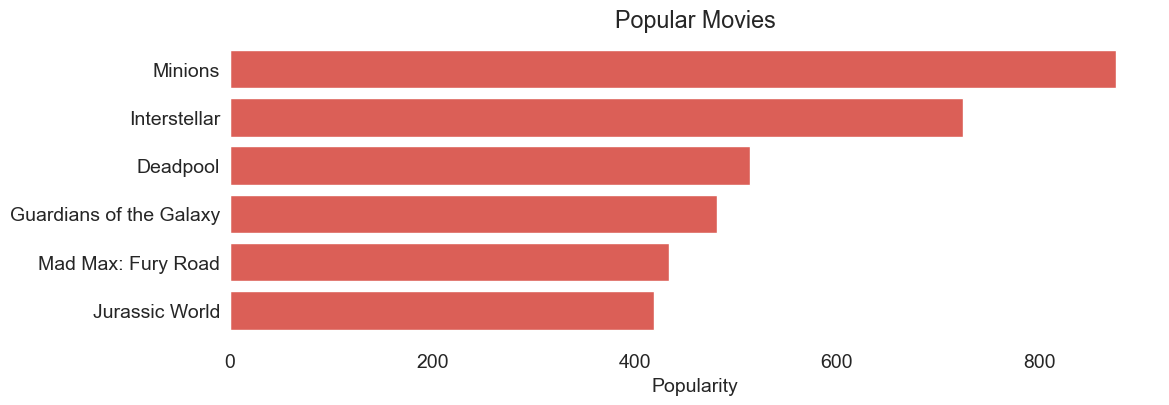

In [48]:
pop= movies_data.sort_values('popularity', ascending=False)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))

plt.barh(pop['title_x'].head(6),pop['popularity'].head(6), align='center')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

Demographic recommenders provide a general chart of recommended movies to all the users, and they are not sensitive to the interests and tastes of a particular user. Therefore, a more intuitive system, like Content-based filtering, would be much better. 

# In summary

My original idea was to create a recommendation system focused on Content-based filtering, but I have also included demographic filtering. I did not include collaboration-based filtering because I do not have a userID, which is necessary for collaborative filtering, and therefore another dataset would have to be used. Frequency is related to the frequency of a word in a document. Inverse Document Frequency is the relative count of documents containing the term given as a log (number of documents/documents with the time). The overall importance of each word to the documents in which they appear is equal to TF * IDF. This gave us a matrix where each column represents a word in the overview vocabulary (all the words that appear in at least one document), and each row represents a movie, as before. This reduces the importance of words frequently occurring in plot overviews and their significance in computing the final similarity score.To save time, TfIdfVectorizer from scikit-learn was used.
There are several ways to calculate similarity scores, such as the Euclidean, Pearson and cosine similarity scores. I used the cosine similarity to calculate a numeric quantity that denotes the similarity between two movies. I am using the cosine similarity score since it is independent of magnitude and relatively easy and fast to calculate. 
Demographic recommenders provide a general chart of recommended movies to all the users, and they are not sensitive to the interests and tastes of a particular user. Therefore, a more intuitive system, like Content-based filtering, would be much better.
